# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM (55 points)
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)


1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

##### Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).

In [24]:

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class PegasosSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lambda_val=0.05, iterations=100) -> None:
        self.lambda_val = lambda_val
        self.iterations = iterations
        self.w = None
        pass

    def fit(self, X, y):
        
        # Convert labels to -1 if needed
        y = self.convert_labels(y)
        

        # Padding 1 instead of bias
        X_padded = self.padding_one(X)

        # Initialize first weight as 0
        self.w = np.zeros(X_padded.shape[1])
            
        sample_set_size = X_padded.shape[0]

        for t in range(1, self.iterations+1):
            # Choose a random sample
            random_sample_idx = np.random.choice(sample_set_size)
            current_x = X_padded[random_sample_idx]
            current_y = y[random_sample_idx]

            # Evaluate the indicator (which incidicates if we add the error in our updated weights) 
            indicator = current_y * np.dot(current_x, self.w)
            indicator = 1. if indicator < 1. else 0.
            
            # Evaluate step size
            step_size = 1. / (self.lambda_val * t) # Notated as eta

            # Update weights
            self.w = (1 - step_size * self.lambda_val) * self.w + indicator * step_size * current_y * current_x
      
    def predict(self, X):
        # Padding
        X_padded = self.padding_one(X)
        # Predicting
        return self.decision_function(self.w @ X_padded.T)

    @staticmethod
    def convert_labels(y):
        y = y.copy()
        y[y==0] = -1
        return y

    @staticmethod
    def decision_function(preds, threshold=0):
        decision_bool_mask = preds<threshold
        preds[decision_bool_mask] = 0
        preds[~decision_bool_mask] = 1
        return preds.astype(np.uint8)

    @staticmethod
    def padding_one(X):
        ones_column = np.ones((X.shape[0], 1))
        return np.hstack((X, ones_column))




#####  test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

seed=42

data = load_breast_cancer()
X = data.get('data')
y = data.get('target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357]))

We will use accuracy as metric since the problem is not highly unbalanced

In [5]:
# Scale dataset
clf_peg = PegasosSVM(lambda_val=0.1, iterations=1000)

cv_scores_peg = cross_val_score(clf_peg, X_train, y_train, cv=10, scoring='accuracy')
print(f"PegasosSVM:\nMean accuracy - {np.mean(cv_scores_peg)}\nCV std - {np.std(cv_scores_peg)}\nCV accuracy results - {cv_scores_peg}")


PegasosSVM:
Mean accuracy - 0.9780193236714976
CV std - 0.013904737859076534
CV accuracy results - [1.         0.97826087 0.97826087 0.95652174 0.97826087 1.
 0.95555556 0.97777778 0.97777778 0.97777778]


In [6]:
from sklearn.svm import LinearSVC

clf_lin = LinearSVC()
cv_scores_lin = cross_val_score(clf_lin, X_train, y_train, cv=10, scoring='accuracy')
print(f"LinearSVC:\nMean accuracy - {np.mean(cv_scores_lin)}\nCV std - {np.std(cv_scores_lin)}\nCV accuracy results - {cv_scores_lin}")

LinearSVC:
Mean accuracy - 0.9692270531400966
CV std - 0.022419883371441518
CV accuracy results - [0.97826087 0.97826087 0.95652174 0.93478261 1.         1.
 0.97777778 0.97777778 0.93333333 0.95555556]


Seems like we got better results than the LinearSVC with default params (Mean accuracy is slightly better and we have lower STD - which means lower variance in the model performance and less randomness).

##### Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 

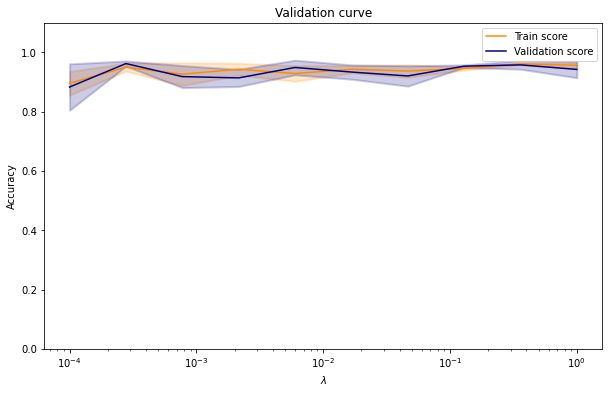

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

param_range = np.logspace(-4, 0, 10)
train_scores, test_scores = validation_curve(PegasosSVM(lambda_val=None, iterations=100), 
                                             X_train, 
                                             y_train, 
                                             param_name="lambda_val", 
                                             param_range=param_range, 
                                             cv=5)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10,6))
plt.title("Validation curve")
plt.xlabel(r"$\lambda$")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Train score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
    alpha=0.2, color="darkorange",lw=lw)
    
plt.semilogx(param_range, test_scores_mean, label="Validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
    alpha=0.2, color="navy",lw=lw)
plt.legend(loc="best")
plt.show()

As we can see, there isn't a big difference between the lambda values and their impact, we can see that for small set of samples the STD is larger so we have higher variance in the results for low lambda values (as probably small step sizes are not converging fast and will require more iterations than what we provided).

##### Analyze the learning curve (performance as function of training size)

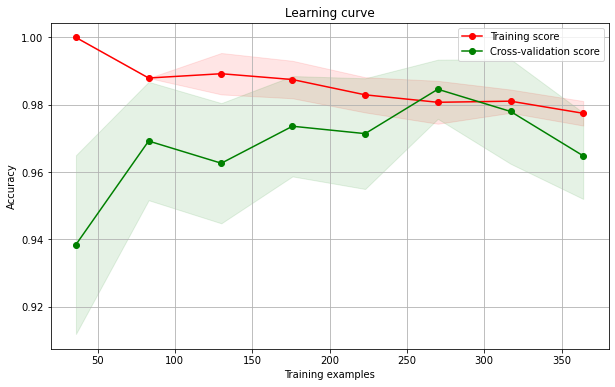

In [28]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(estimator=PegasosSVM(iterations=1000, lambda_val=0.1), 
                                            X=X_train, 
                                            y=y_train, 
                                            train_sizes=np.linspace(0.1, 1.0, 8),
                                            cv=5)

plt.figure(figsize=(10,6))
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
    train_sizes, valid_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend(loc="best")

As we see, we start with a very high score for the training set (as we evaluate ourselves only on samples we've seen) and a lower score for the validation set, as we see more samples the validation improves (and train performance decreases).

In addition, it looks like somewhere around 270 iterations we get the best validation score and from there the performance decreases (as we are probably overfitting to the train seen samples).

## 2. The importance of class weighting in SVM (15)
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


##### For `d=10` and `d=2` plot the scatter plot of the data.

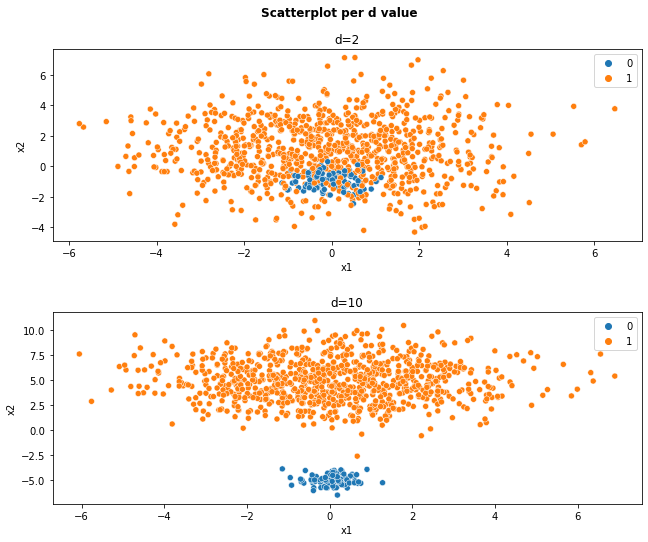

In [17]:
import seaborn as sns

def make_data(d):

    n_samples=1000

    # Initialize samples
    x_samples = np.empty((n_samples,2))

    # P(y=0) = 0.1 - Binomial
    y_samples = np.random.binomial(n=1, p=0.9, size=n_samples)


    mu1=0

    for i in range(n_samples-1):

        if y_samples[i] == 0:
            sigma = 0.5
            mu2 = -d/2
        else:
            sigma = 2
            mu2 = d/2 
            
        x_samples[i] = [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]

    return x_samples, y_samples
    

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
fig.tight_layout(pad=5.0)
fig.suptitle('Scatterplot per d value', fontweight ="bold")

# d=2 plotting
x_samples_d2, y_samples_d2 = make_data(2)
ax2 = sns.scatterplot(ax=axes[0],x=x_samples_d2[:, 0], y=x_samples_d2[:, 1], hue=y_samples_d2)
ax2.set(xlabel= 'x1', ylabel='x2', title="d=2")


# d=10 plotting
x_samples_d10, y_samples_d10 = make_data(10)
ax1 = sns.scatterplot(ax=axes[1], x=x_samples_d10[:, 0], y=x_samples_d10[:, 1], hue=y_samples_d10)
ax1.set(xlabel= 'x1', ylabel='x2', title="d=10")



plt.show()

##### Where would you think the SVM hyperplane will lie?

**d=2**

I assume that the hyperplane will probably be around the line x2 = 0, it's not really clear but maybe it will split by that line we will have "minimal" mistakes. 


**d=10**

It is pretty clear that the hyperplane will be a line between (x1=0, x2=0) to (x1=7, x2=0) - I assume the maximal margin is somewhere around there

##### Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

In [18]:
def plot_svm(clf, X, y, additional_str):
    clf.fit(X, y)

    plt.figure()
    plt.clf()
    plt.scatter(
        X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20
    )


    plt.axis("tight")
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-0.5, 0, 0.5],
    )
    plt.title(f"SVM hyperplane plot - {additional_str}")
    return plt

**d=2 hyperplane plot**

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36395/2528821680.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


<module 'matplotlib.pyplot' from '/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/matplotlib/pyplot.py'>

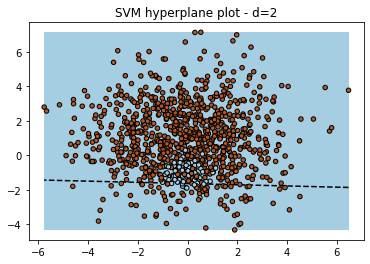

In [22]:
plot_svm(LinearSVC(), x_samples_d2, y_samples_d2, 'd=2')

**d=10 hyperplane plot**

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36395/2528821680.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


<module 'matplotlib.pyplot' from '/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/matplotlib/pyplot.py'>

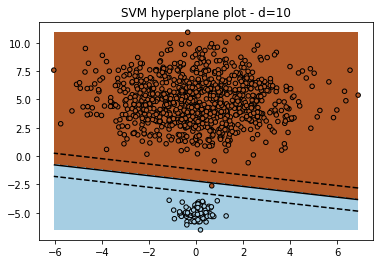

In [23]:
plot_svm(LinearSVC(), x_samples_d10, y_samples_d10, 'd=10')

##### Repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36395/2528821680.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


<module 'matplotlib.pyplot' from '/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/matplotlib/pyplot.py'>

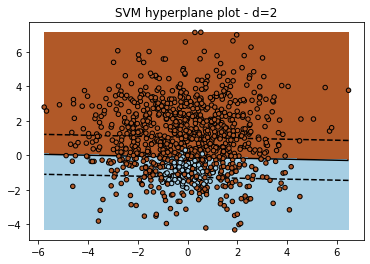

In [24]:
plot_svm(LinearSVC(class_weight='balanced'), x_samples_d2, y_samples_d2, 'd=2')

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36395/2528821680.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


<module 'matplotlib.pyplot' from '/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/matplotlib/pyplot.py'>

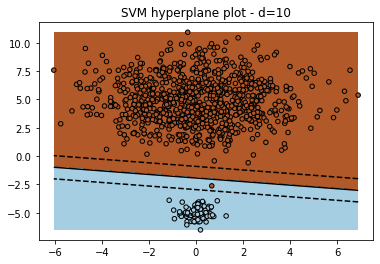

In [25]:
plot_svm(LinearSVC(class_weight='balanced'), x_samples_d10, y_samples_d10, 'd=10')

We see that we for an improvement for d=2, with the defualt params the original class weight for all the samples is 1.

Due to the fact that the weights are the same and that the number of 0 labeled samples is not proportional to the 1 labeled samples (1/9), the algorithm with the default settings uses a const regularization term which causes the bad results (punishment for mistakes are not adjusted per class).

If we use "`class_weight='balanced'`", we get a regularization term that is set proportionally to the classes (0 / 1) frequencies in the data which solves this problem (according to the docs - "`n_samples / (n_classes * np.bincount(y))`").

## 3. SVM hyperparameter search (10)
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [194]:
from sklearn.model_selection import GridSearchCV

seed=42
np.random.seed(seed)

parameters = {
    'multi_class': ['ovr', 'crammer_singer'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.logspace(-3, 3, 10),
}

model = LinearSVC()

grid_clf = GridSearchCV(model, parameters, scoring='accuracy')
grid_clf.fit(X=X_train, y=y_train)

grid_clf.best_params_

/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adahan/opt/an

{'C': 0.021544346900318832, 'loss': 'hinge', 'multi_class': 'ovr'}

In [199]:
from sklearn.svm import LinearSVC

clf_default = LinearSVC()
cv_scores_lin = cross_val_score(clf_default, X_train, y_train, cv=10, scoring='accuracy')
print(f"LinearSVC (default params):\nMean accuracy - {np.mean(cv_scores_lin)}\nCV std - {np.std(cv_scores_lin)}\nCV accuracy results - {cv_scores_lin}\nParams - {clf_default.get_params()}")

LinearSVC (default params):
Mean accuracy - 0.9692270531400966
CV std - 0.022419883371441518
CV accuracy results - [0.97826087 0.97826087 0.95652174 0.93478261 1.         1.
 0.97777778 0.97777778 0.93333333 0.95555556]
Params - {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [201]:
from sklearn.svm import LinearSVC

clf_optimized = LinearSVC(**grid_clf.best_params_)
cv_scores_lin = cross_val_score(clf_optimized, X_train, y_train, cv=10, scoring='accuracy')
print(f"LinearSVC (optimized params):\nMean accuracy - {np.mean(cv_scores_lin)}\nCV std - {np.std(cv_scores_lin)}\nCV accuracy results - {cv_scores_lin}\nParams - {clf_optimized.get_params()}")

LinearSVC (optimized params):
Mean accuracy - 0.9757971014492753
CV std - 0.015455087080942053
CV accuracy results - [1.         0.97826087 0.97826087 0.95652174 0.97826087 1.
 0.95555556 0.97777778 0.97777778 0.95555556]
Params - {'C': 0.021544346900318832, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


We see that the params optimization yields lower variance in the performance (accuracy-wise) and also improved the mean accuracy sligthly.

## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [1]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

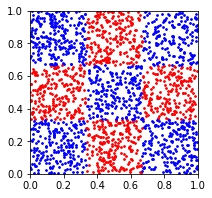

In [15]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(2000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [35]:
from sklearn.metrics import f1_score

def plot_svm(clf, X_train, X_test, y_train, y_test, name):
    clf.fit(X_train, y_train)

    # plt.figure()
    plt.clf()
    plt.scatter(
        X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20
    )

    # Circle out the test data
    plt.scatter(
        X_test[:, 0], X_test[:, 1], s=80, facecolors="none", zorder=10, edgecolor="k"
    )

    plt.axis("tight")
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-0.5, 0, 0.5],
    )
    f1 = f1_score(clf.predict(X_test), y_test)
    plt.title(name + f" [f1: {f1}]")
    return plt


### Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use

##### Polynomial kernel degree

As polynomial degrees are limited to a small set of numbers (since calculation for degree > 7/8 are heavy), lets train per each degree in the range of 1-6 and evaluate the F1 score on the test set.

In [53]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

seed=42
np.random.seed(seed)


grid_search_params = {
    'kernel': ['poly'],
    'degree': list(range(1, 7)),
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 10]
}

model = svm.SVC()

# Using accuracy since the classes are pretty much balanced here
grid_clf = GridSearchCV(model, grid_search_params, scoring='accuracy')
grid_clf.fit(X=X_train, y=y_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
                         'degree': [1, 2, 3, 4, 5, 6], 'kernel': ['poly']},
             scoring='accuracy')

In [54]:
grid_clf.best_params_

{'C': 10, 'degree': 6, 'kernel': 'poly'}

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


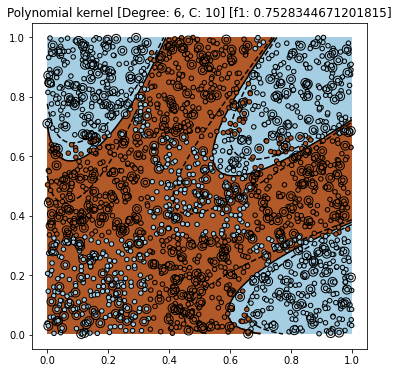

In [55]:

plt.figure(figsize=(6,6))
deg = grid_clf.best_params_.get('degree')
c = grid_clf.best_params_.get('C')
_ = plot_svm(grid_clf.best_estimator_, X_train, X_test, y_train, y_test, f"Polynomial kernel [Degree: {deg}, C: {c}]")
plt.show()

Seems like polynomial kernel gets a decent part of the samples correctly, but it doesn't look like the optimal solution for our case.

##### RBF Kernel

Let's get some intuition for the gamma param and RBF kernel relation:

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


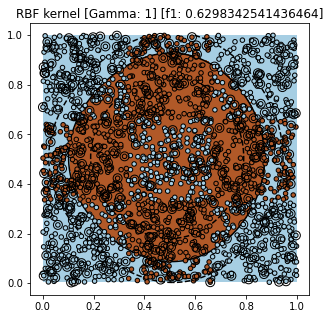

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


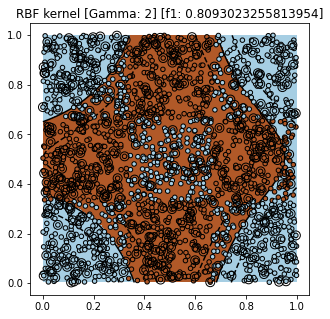

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


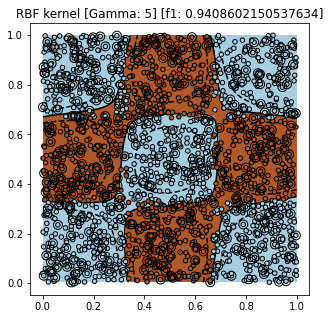

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


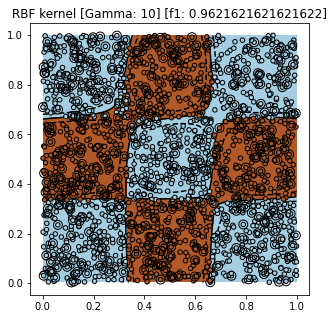

In [49]:
from sklearn import svm

for i in [1, 2, 5, 10]:
    plt.figure(figsize=(5,5))
    clf = svm.SVC(kernel='rbf', gamma=i, C=1)
    _ = plot_svm(clf, X_train, X_test, y_train, y_test, f"RBF kernel [Gamma: {i}]")
    plt.show()

Let's find the optimal gamma and C by using grid search and CV

In [50]:
from sklearn import svm


seed=42
np.random.seed(seed)


grid_search_params = {
    'kernel': ['rbf'],
    'gamma': [1, 2, 5, 10, 15, 30],
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 30, 50, 100]
}

model = svm.SVC()

grid_clf_rbf = GridSearchCV(model, grid_search_params, scoring='accuracy')
grid_clf_rbf.fit(X=X_train, y=y_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 30, 50, 100],
                         'gamma': [1, 2, 5, 10, 15, 30], 'kernel': ['rbf']},
             scoring='accuracy')

In [51]:
grid_clf_rbf.best_params_

{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_64222/3034167487.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


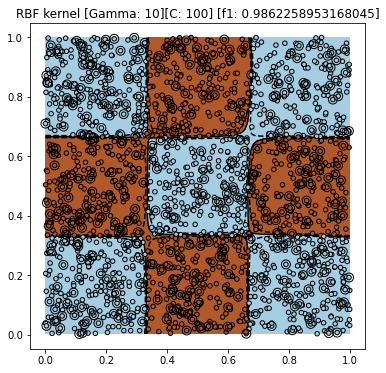

In [52]:

plt.figure(figsize=(6,6))
gamma = grid_clf_rbf.best_params_.get('gamma')
c = grid_clf_rbf.best_params_.get('C')
_ = plot_svm(grid_clf_rbf.best_estimator_, X_train, X_test, y_train, y_test, f"RBF kernel [Gamma: {gamma}][C: {c}]")
plt.show()

As we can see we got the best results with gamma=10 and C=100 (F1 score of 0.98622).

High C value makes sense as high C usuallt refers to a smaller margin hyperplane, which in our case makes sense as we have clear "checkerboard lines" that separate classes.

It seems that in our case, the best model and kernel is the RBF kernel with the params:
- Gamma=10
- C=100

I would choose this model rather than the polynomial one.

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

